# SYDE556/750 Assignment 3: Connecting Neurons

- Due Date: March 6th
- Total marks: 10 (10% of final grade)
- Late penalty: 1 mark per day
- It is recommended that you Python.
- Do not use any code from Nengo

## 1) Decoding from a population

As you did in previous assignments, make a population of 20 LIF neurons representing a 1-dimensional value, and compute a decoder for them.  For parameters, $\tau_{ref}$=0.002s, $\tau_{RC}$=0.02s, the maximum firing rates are chosen randomly from a uniform distribution between 100 and 200Hz (at the max radius), and the x-intercepts are chosen randomly from a uniform distribution between -2 and 2.  Remember that the $\alpha$ and $J^{bias}$ terms are computed based on these x-intercepts and maximum firing rates.

It is generally easiest to compute decoders using the original method from Assignment 1, where we use the rate-mode approximation for the neurons to generate the $A$ matrix, then find $\Gamma=A^T A + \sigma^2 I$.  You can use this approach to find decoders, and these decoders should work even when you simulate the neurons in terms of spikes (in question 2 on).  The only difference will be that they will need to be scaled by ``dt``, your simulation time step.

Use method for computing decoders for this whole assignment.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the tuning curves (firing rate of each neuron for different $x$ values between -2 and 2)</li>
</ol>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy


def calc_rms(x):
    return np.sqrt(np.mean(np.power(x,2)))


In [2]:
class LIFNeuron:
    
    def __init__(self, enc=1, tau_ref=0.002, tau_rc=0.02, min_rate=100, max_rate=200, alpha=None, j_bias=None):
        self.x_int = np.random.uniform(-2,2)
        self.min_rate = min_rate
        self.max_rate = max_rate
        self.enc = enc
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        self.encoder = np.random.choice([1,-1])
        if alpha is None and j_bias is None:
            self.j_bias = 1/(1-np.exp((self.tau_ref-(1/self.min_rate))/self.tau_rc))
            self.alpha = 1/(1-np.exp((self.tau_ref-(1/self.max_rate))/self.tau_rc))-self.j_bias
        else: 
            self.j_bias = j_bias
            self.alpha = alpha
    
            
    def get_spikes(self, x, dt):
        
        
        
        number_of_spikes = 0
        spikes = []
        v,i = 0,0
        while i < len(x):
            J = self.alpha*x[i]*self.enc + self.j_bias
            if v >= 1:
                v = 1.5
                number_of_spikes +=1
                if len(spikes) < len(x): spikes.append(v)
                v,j = 0,0
                while(j<self.tau_ref/dt):
                    i,j=i+1,j+1
                    if len(spikes) < len(x): spikes.append(v)
                v = v + dt*(1/self.tau_rc)*(J - v)
                i += 1        
                continue
            elif v < 0:
                v = 0
                if len(spikes) < len(x): spikes.append(v)
            else:    
                if len(spikes) < len(x): spikes.append(0)
           
            v = v + dt*(1/self.tau_rc)*(J - v)
            i += 1        
        return number_of_spikes, spikes
    
    def get_rates(self, x):
        
        firing_rate = np.random.uniform(self.min_rate, self.max_rate)
        J_max = 1/(1 - np.exp((self.tau_ref - 1/firing_rate)/self.tau_rc))
        self.alpha = (J_max - 1)/(2 - self.encoder*self.x_int)
        self.j_bias = 1 - self.alpha*self.encoder*self.x_int
        
        rates = []
        for pos in x:
            rate = 0
            J = self.alpha*pos*self.encoder+self.j_bias
            if J > 1:
                rate = 1/(self.tau_ref - self.tau_rc*np.log(1 - 1/J))
            rates.append(rate)
        return rates

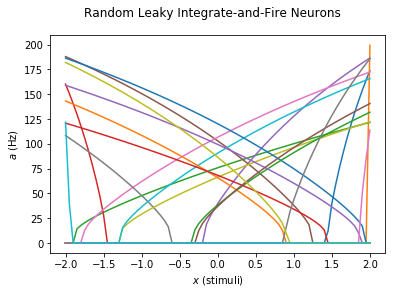

In [3]:
dt = 0.001


def generate_LIF_neurons(num, stimuli):
    neurons = []
    rates = []
    for i in range(num):
        n = LIFNeuron()
        neurons.append(n)
        s = n.get_rates(stimuli)
        rates.append(s)
    return neurons, rates


plt.figure()
plt.suptitle('Random Leaky Integrate-and-Fire Neurons')

num_neurons = 20
number_of_samples = 81 # samples
x = np.linspace(-2,2,number_of_samples)
neurons, rates = generate_LIF_neurons(num_neurons, x)
for neuron, nrate in zip(neurons, rates):
    plt.plot(x, nrate)

plt.xlabel('$x$ (stimuli)')
plt.ylabel('$a$ (Hz)')
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li> [0.5 marks] Compute the decoders and plot $(x-\hat{x})$.  When computing decoders, take into account noise ($\sigma$=0.1 times 200Hz).  When computing $\hat{x}$, add random gaussian noise with $\sigma$=0.1 times 200Hz to the activity. Report the Root Mean-Squared Error (RMSE).</li>
</ol>

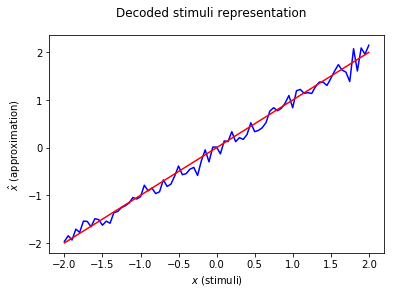

In [4]:
A = np.transpose(rates)
stddev_noise = 0.1*200

gamma_noisy = np.dot(np.transpose(A),A)/number_of_samples + np.power(stddev_noise,2)*np.identity(A.shape[1])
upsilon = np.dot(np.transpose(A),x)/number_of_samples
decoders = np.dot(np.linalg.inv(gamma_noisy),upsilon)

gauss_noise = np.random.normal(scale=stddev_noise,size=np.shape(A))
x_approx = np.dot(A + gauss_noise,decoders)

plt.figure()
plt.suptitle('Decoded stimuli representation')
plt.plot(x,x_approx,'b')
plt.plot(x,x,'r')
plt.xlabel('$x$ (stimuli)')
plt.ylabel(r'$\hat x$ (approximation)')
plt.show()

## 2) Decoding from two spiking neurons

Choose a neuron from part 1 that has a firing rate of somewhere between 20-50Hz for $x$=0.  Using that neuron's $\alpha$ and $J^{bias}$ value, construct two neurons: both with the same $\alpha$ and $J^{bias}$, but one with $e$=+1 and the other with $e$=-1.  With the function from the last assignment, generate a random input $x(t)$ that is 1 second long, with rms=1, dt=0.001, and an upper limit of 5Hz.  Feed that signal into the two neurons and generate spikes.  Decode the spikes back into $\hat{x}(t)$ using a post-synaptic current filter $h(t)$ with a time constant of $\tau$=0.005.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the post-synaptic current $h(t)=e^{-t/\tau}/ \int e^{-t/\tau} dt$</li>
</ol>

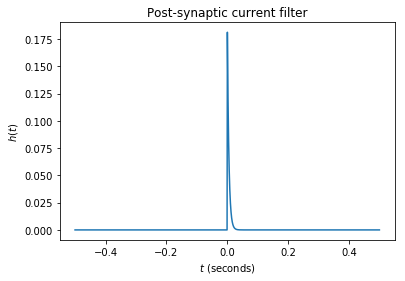

In [12]:
def generate_signal(T, dt, rms, limit, seed=0):
    
    np.random.seed(seed=seed)
    
    number_of_samples = int(T/dt)
    frequencies=np.arange(number_of_samples)/T - number_of_samples/(2*T)
    X = np.zeros(len(frequencies)).tolist()
    
    for i, f in enumerate(frequencies):
        if abs(f) <= limit:
            real, imag = np.random.normal(), np.random.normal()*1j
            X[i] = real + imag
            if f < 0: X[i] = real - imag
       
    x =np.fft.ifft(np.fft.ifftshift(X)).real
    x_rms = np.sqrt(np.mean(np.power(x,2)))
    x = [val*rms/(x_rms) for val in x]
    X = np.fft.fftshift(numpy.fft.fft(x))   
    return x,X

index_of_x_zero = np.where(x==0)[0][0]

neuron_20_50 = None
for i in range(len(A[index_of_x_zero])):
    val = A[index_of_x_zero][i]
    if val>=20 and val<=50:
        neuron_20_50 = neurons[i]
        break
        
neuron_1 = LIFNeuron(alpha=neuron_20_50.alpha, j_bias=neuron_20_50.j_bias, enc=1)
neuron_2 = LIFNeuron(alpha=neuron_20_50.alpha, j_bias=neuron_20_50.j_bias, enc=-1)

T, rms, dt, limit = 1, 1, 0.001, 5
t = np.arange(0,T,dt)
sig, X = generate_signal(T=T,rms=rms,dt=dt,limit=limit)



spikes = []
_, s = neuron_1.get_spikes(sig,dt)
spikes.append(s)
_, s = neuron_2.get_spikes(sig,dt)
spikes.append(s)


tau = 0.005
t_h = np.arange(1000)*dt - 0.5
h = np.exp(-t_h/tau)
h[np.where(t_h<0)]=0
h = h/np.linalg.norm(h,1)

plt.title('Post-synaptic current filter')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$h(t)$')
plt.plot(t_h,h)
plt.show()